In [16]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import math
from scipy import stats
import h5py
from sklearn.preprocessing import normalize

*IMPORTANT: PLEASE READ THE REPORT BEFORE GOING OVER THE CODE*

Consider population dataset of Canadian Lynx and Snowshoe Hare from 1845 to 1903, a DMD model is developped to forecast the future population states.

In [17]:
#load data
x=np.array([[20,20,52,83,64,68,83,12,36,150,110,60,7,10,10,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65],
            [32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25]])
t = np.arange(0, 30) 

In [18]:
#data interpolation to 580 points
tck0 = interpolate.splrep(t, x[0,:], s=0)
tck1 = interpolate.splrep(t, x[1,:], s=0) 
tnew = np.arange(0, 29, step=0.05)
xnew0 = interpolate.splev(tnew, tck0, der=0)
xnew1 = interpolate.splev(tnew, tck1, der=0)
xnew=np.stack((xnew0, xnew1)) 

In [19]:
#define DMD model
def DMD(X,Xprime,r):
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

In [20]:
#fit DMD model with interpolated data
Phi, Lambda, b = DMD(xnew[:,0:-1],xnew[:,1:],r=2) 

In [21]:
#reconstruct the original data using DMD
mu = np.diag(Lambda)
dt=tnew[2]-tnew[1]
omega = np.log(mu)/dt;
u_modes = np.zeros([2,len(tnew)],dtype=complex) 
for i in range(len(tnew)):
    u_modes[:,i] =b*np.exp(omega*(tnew[i]))
u_dmd = np.abs(np.real(np.dot(Phi,u_modes)))

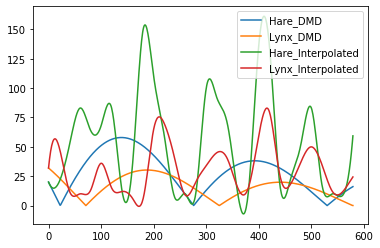

In [85]:
#visualize and compare the original data and reconstructed data
plt.plot(u_dmd[0,:],label="Hare_DMD")
plt.plot(u_dmd[1,:],label="Lynx_DMD")
plt.plot(xnew[0,:],label="Hare_Interpolated")
plt.plot(xnew[1,:],label="Lynx_Interpolated")
plt.legend()
plt.savefig('dmd.jpg')

 Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. 

In [23]:
#define Hankel matrix
H=[xnew[0,0:573],xnew[1,0:573],xnew[0,1:574],xnew[1,1:574],xnew[0,2:575],xnew[1,2:575],xnew[0,3:576],xnew[1,3:576],xnew[0,4:577],xnew[1,4:577],xnew[0,5:578],xnew[1,5:578],xnew[0,6:579],xnew[1,6:579]]
H=np.asarray(H)
print("the shape of the Hankel matrix is",H.shape)

the shape of the Hankel matrix is (14, 573)


In [24]:
#singular value decomposition to find latent variables
U,S,V = np.linalg.svd(H,full_matrices=0) 

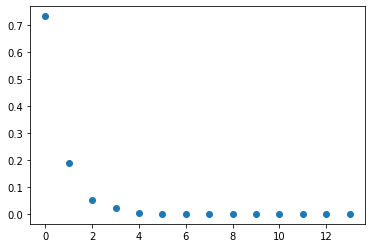

In [87]:
#visualize the eigenvalues
ev_per=S/sum(S)
plt.plot(ev_per,'o')
plt.savefig('eigvH.jpg')

In [26]:
#fit DMD model with Hankel matrix, here we know that this is a rank 2 system fromm the eigenvalue visualization
PhiH, LambdaH, bH = DMD(H[:,:-1],H[:,1:],r=2)  

In [27]:
#reconstruct the hankel matrix usibg DMD model
muH = np.diag(LambdaH)
dt=tnew[2]-tnew[1]
omegaH = np.log(muH)/dt;
u_modesH = np.zeros([2,len(tnew)],dtype=complex) 
for i in range(len(tnew)):
    u_modesH[:,i] =bH*np.exp(omegaH*(tnew[i]))
H_dmd = np.abs(np.real(np.dot(PhiH,u_modesH)))

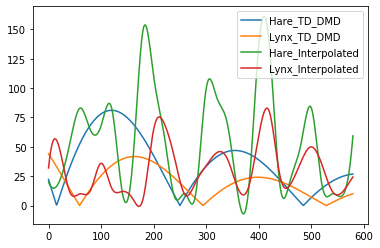

In [88]:
#visualize and compare the original data and reconstructed data, only the first two rows are taken becasue we know this is a 2 dimensional system
plt.plot(H_dmd[0,:],label="Hare_TD_DMD")
plt.plot(H_dmd[1,:],label="Lynx_TD_DMD")
plt.plot(xnew[0,:],label="Hare_Interpolated")
plt.plot(xnew[1,:],label="Lynx_Interpolated")
plt.legend()
plt.savefig('DMDH.jpg')

Empirical Predator-Preymodels such as Lotka-Volterra are commonly used to model such phenomenon. 

The predator-prey model is summarized by these equations:

$$
\frac{dx}{dt} = b x - p x y \\
\frac{dy}{dt} = r x y - d y
$$


In [29]:
#To find the parameters, calculate xdot and ydot first
x1=xnew[0,:]
x2=xnew[1,:]
n=len(tnew)
dt=tnew[1]-tnew[0]
x1dot=np.zeros(n-3)
x2dot=np.zeros(n-3)
for j in range(1,n-2):
    x1dot[j-1]=(x1[j+1]-x1[j-1])/(2*dt)
    x2dot[j-1]=(x2[j+1]-x2[j-1])/(2*dt)

In [30]:
#re-define the range of x and y
x1s=x1[1:n-2]
x2s=x2[1:n-2]

In [31]:
#find out the parameters' least square solution
A1=np.array([x1s,x1s*x2s]).T
A2=np.array([x2s,x1s*x2s]).T
b=np.linalg.lstsq(A1,x1dot,rcond=None)[0][0]
p=-np.linalg.lstsq(A1,x1dot,rcond=None)[0][1]
d=-np.linalg.lstsq(A2,x2dot,rcond=None)[0][0]
r=np.linalg.lstsq(A2,x2dot,rcond=None)[0][1]

In [32]:
print("b is",b,"p is",p,"d is",d,"r is",r)

b is 0.4452449885824652 p is 0.010523706938177165 d is 0.4440500582662361 r is 0.005489134998737023


Find the best ﬁt nonlinear, dynamical systems model to the data using sparse regression.

In [33]:
#model discovery dictionary
Theta=np.array([x1s,x2s,x1s*x2s,np.power(x1s,2),np.power(x2s,2),np.power(x1s,2)*x2s,np.power(x2s,2)*x1s,np.power(x1s,3),np.power(x2s,3),np.sin(x1s),np.cos(x1s),np.sin(x2s),np.cos(x2s)]).T

In [34]:
#define sparse regression
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

In [35]:
#fit the model
x1_x=sparsifyDynamics(Theta,x1dot,lamb=0.5, n=0)
x2_x=sparsifyDynamics(Theta,x2dot,lamb=0.5, n=0)

In [36]:
x1_x

array([ 1.28575951, -1.02092223,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  2.16417123,
        0.        ,  4.45864796,  0.73351141])

In [37]:
x2_x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.51646335,
       -0.77086155, -0.96402735,  0.        ])

Compute the KL divergence of the best model ﬁt to the data between all the above models.

In [38]:
#normalize original data
nxnew= normalize(xnew,axis=1)
xnew0=nxnew[0,:]
xnew1=nxnew[1,:]
x1s=x1s.reshape(-1, 1)
x2s=x2s.reshape(-1, 1)
nx1s= normalize(x1s,axis=0)
nx2s= normalize(x2s,axis=0)

In [39]:
#estimate the density distribution of original data
trued_0 = np.histogram(xnew0,bins=50,range=(0,1),density=True)
trued_1 = np.histogram(xnew1,bins=50,range=(0,1),density=True)
dtrue_0 = np.histogram(nx1s,bins=50,range=(0,1),density=True)
dtrue_1 = np.histogram(nx2s,bins=50,range=(0,1),density=True)

In [40]:
#normalize the reconstructed data of dmd and estimate the density distribution
nu_dmd= normalize(u_dmd,axis=1)
d_dmd0 = np.histogram(nu_dmd[0,:],bins=50,range=(0,1),density=True)
d_dmd1 = np.histogram(nu_dmd[1,:],bins=50,range=(0,1),density=True)

In [41]:
# calculate the kl divergence (relative entropy) with scipy
from scipy.stats import entropy
kl_dmd0=entropy(trued_0[0],d_dmd0[0]+0.0001)
kl_dmd1=entropy(trued_1[0],d_dmd1[0]+0.0001)
print("The KL divergence of DMD model for Hare is",kl_dmd0,",for Lynx is",kl_dmd1)

The KL divergence of DMD model for Hare is 0.6948004127723106 ,for Lynx is 0.6669934219019018


In [42]:
#repeat the steps above(normalize reconstructed data of the model-> estimate density distribution->calculate kl divergence)
nH_dmd= normalize(H_dmd,axis=1)
d_H0 = np.histogram(nH_dmd[0,:],bins=50,range=(0,1),density=True)
d_H1 = np.histogram(nH_dmd[1,:],bins=50,range=(0,1),density=True)
kl_H0=entropy(trued_0[0],d_H0[0]+0.0001)
kl_H1=entropy(trued_1[0],d_H1[0]+0.0001)
print("The KL divergence of Time Delayed DMD model for Hare is",kl_H0,",for Lynx is",kl_H1)

The KL divergence of Time Delayed DMD model for Hare is 0.714400543429 ,for Lynx is 0.6501985073447558


In [43]:
#repeat the steps above(normalize reconstructed data of the model-> estimate density distribution->calculate kl divergence)
coef0=np.linalg.lstsq(A1,x1dot,rcond=None)[0]
coef1=np.linalg.lstsq(A2,x2dot,rcond=None)[0]
lv0=A1@coef0.reshape(-1, 1)
lv1=A2@coef1.reshape(-1, 1)
nlv0= normalize(lv0,axis=0)
nlv1= normalize(lv1,axis=0)
d_lv0 = np.histogram(nlv0,bins=50,range=(0,1),density=True)
d_lv1 = np.histogram(nlv1,bins=50,range=(0,1),density=True)
kl_lv0=entropy(dtrue_0[0],d_lv0[0]+0.0001)
kl_lv1=entropy(dtrue_1[0],d_lv1[0]+0.0001)
print("The KL divergence of Lotka-Volterra model for Hare is",kl_lv0,",for Lynx is",kl_lv1)

The KL divergence of Lotka-Volterra model for Hare is 0.29199236713117505 ,for Lynx is 0.25865117944415805


In [44]:
#repeat the steps above(normalize reconstructed data of the model-> estimate density distribution->calculate kl divergence)
ls0= Theta@x1_x.reshape(-1, 1)
ls1= Theta@x2_x.reshape(-1, 1)
nls0= normalize(ls0,axis=0)
nls1= normalize(ls1,axis=0)
d_ls0 = np.histogram(nls0,bins=50,range=(0,1),density=True)
d_ls1 = np.histogram(nls1,bins=50,range=(0,1),density=True)
kl_ls0=entropy(dtrue_0[0],d_ls0[0]+0.0001)
kl_ls1=entropy(dtrue_1[0],d_ls1[0]+0.0001)
print("The KL divergence of Sparse Regression model for Hare is",kl_ls0,",for Lynx is",kl_ls1)

The KL divergence of Sparse Regression model for Hare is 0.07908094391063233 ,for Lynx is 0.0871384396985428


Retain three of your best ﬁt models and compare their AIC and BIC scores- DMD, Lotka-Volterra model and Sparse Regression.

In [45]:
#define AIC nad BIC formulas with residual sum of squares
def AIC_BIC(x1,x2,K,n,model_name):
    AIC=2*K + n*math.log(np.sum(np.power((x1-x2),2))/n)
    BIC=K*math.log(n)+ n*math.log(np.sum(np.power((x1-x2),2))/n)
    return print("The AIC score of model",model_name,"is",AIC,",BIC score is",BIC)

In [46]:
#show the results
AIC_BIC(xnew[0,:],u_dmd[0,:],K=2,n=580,model_name='DMD for Hare')
AIC_BIC(xnew[1,:],u_dmd[1,:],K=2,n=580,model_name='DMD for Lynx')
AIC_BIC(x1s,lv0,K=2,n=580,model_name='Lotka-Volterra for Hare')
AIC_BIC(x2s,lv1,K=2,n=580,model_name='Lotka-Volterra for Lynx')
AIC_BIC(x1s,ls0,K=5,n=580,model_name='Sparse Regression for Hare')
AIC_BIC(x2s,ls1,K=3,n=580,model_name='Sparse Regression for Lynx')

The AIC score of model DMD for Hare is 4472.7931682996405 ,BIC score is 4481.519224506721
The AIC score of model DMD for Lynx is 3727.1783005869706 ,BIC score is 3735.9043567940516
The AIC score of model Lotka-Volterra for Hare is 4939.508620572391 ,BIC score is 4948.234676779472
The AIC score of model Lotka-Volterra for Lynx is 4218.36475483896 ,BIC score is 4227.0908110460405
The AIC score of model Sparse Regression for Hare is 3724.468755251711 ,BIC score is 3746.2838957694134
The AIC score of model Sparse Regression for Lynx is 4174.86986558003 ,BIC score is 4187.958949890652


Use *BZ.mat*(which is a snipet from a Belousov-Zhabotinsky chemical oscillator movie) to fit DMD and Time Delayed DMD models

In [47]:
#load data
filepath = 'C:/Users/glori/BZ.mat'
BZ = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    BZ[k] = np.array(v)

In [48]:
#reformat the data as n*k pixels(rows) and m snapshots(columns)
data=BZ['BZ_tensor']
[m,n,k]=data.shape
BZ=np.zeros((n*k,m))
for i in range(m):
    BZ[:,i]=data[i,:,:].flatten()

In [49]:
#fit DMD model with reformatted data
BZPhi, BZLambda, BZb = DMD(BZ[:,0:-1],BZ[:,1:],r=2)  

In [50]:
#reconstruct the DMD model
BZmu = np.diag(BZLambda)
BZt=np.arange(0, 1200)
BZdt=1
BZomega = np.log(BZmu)/BZdt;
BZ_modes = np.zeros([2,1200],dtype=complex) 
for i in range(1200):
    BZ_modes[:,i] =BZb*np.exp(BZomega*(BZt[i]))
BZ_dmd = np.abs(np.real(np.dot(BZPhi,BZ_modes)))

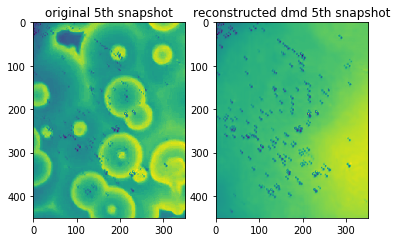

In [97]:
#visualize and compare the originial and reconstructed 5th snapshots  
figure=plt.subplots(1,2)
sample=data[5,:,:]
ax0=plt.subplot(1,2,1)
plt.imshow(sample)
ax0.set_title('original 5th snapshot')
ax1=plt.subplot(1,2,2)
recon_s=np.reshape(BZ_dmd[:,5],(n,k))
ax1.set_title('reconstructed dmd 5th snapshot')
plt.imshow(recon_s)
plt.savefig('123.jpg')

In [62]:
#construct the Hanzel matrix of BZ for time delayed DMD
s=BZ.shape[0]
BZH=np.zeros((s*10,100))
for j in range(10):
    for i in range(s):
        BZH[j*s+i,:]=BZ[i,j:100+j]

In [66]:
#as before, find the singular value decomosition
BZU,BZS,BZV = np.linalg.svd(BZH,full_matrices=0) 

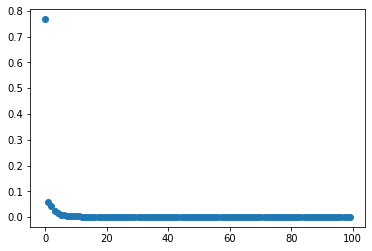

In [90]:
BZev_per=BZS/sum(BZS)
plt.plot(BZev_per,'o')
plt.savefig('eigenvbz.jpg')

In [68]:
#fit DMD model with Hankel matrix, here we know that this is a rank 1 system fromm the eigenvalue visualization
BZPhiH, BZLambdaH, BZbH = DMD(BZH[:,:-1],BZH[:,1:],r=1)  

In [69]:
#reconstruct the DMD model
BZmuH = np.diag(BZLambdaH)
dt=1
BZt=np.arange(0, 10)
BZomegaH = np.log(BZmuH)/dt;
BZ_modesH = np.zeros([1,10],dtype=complex) 
for i in range(10):
    BZ_modesH[:,i] =BZbH*np.exp(BZomegaH*(BZt[i]))
BZH_dmd = np.abs(np.real(np.dot(BZPhiH,BZ_modesH)))

In [82]:
#Compare models with AIC and BIC score
AIC_BIC(BZ[0,:],BZ_dmd[0,:],K=2,n=s,model_name='DMD for BZ')
AIC_BIC(BZ[0,0:10],BZH_dmd[0,:],K=1,n=s,model_name='Time Delayed DMD for BZ')

The AIC score of model DMD for BZ is 109510.14994948007 ,BIC score is 109530.094456606
The AIC score of model Time Delayed DMD for BZ is -650027.2852419238 ,BIC score is -650017.3129883608


**Thank you for reading!**